## Tutorial 3.3

The Linnerud dataset is a multi-output regression dataset. It consists of three excercise (data) and three physiological (target) variables collected from twenty middle-aged men in a fitness club:

physiological - CSV containing 20 observations on 3 physiological variables: Weight, Waist and Pulse.

exercise - CSV containing 20 observations on 3 exercise variables: Chins, Situps and Jumps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import torch
from torch import nn

In [2]:
SEED = 100
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
from sklearn.datasets import load_linnerud

X, y = load_linnerud(return_X_y=True)

In [4]:
df1 = pd.DataFrame(y, columns=["weight","waist","pulse"])
print(df1[:5])

   weight  waist  pulse
0   191.0   36.0   50.0
1   189.0   37.0   52.0
2   193.0   38.0   58.0
3   162.0   35.0   62.0
4   189.0   35.0   46.0


In [5]:
df2 = pd.DataFrame(X, columns=["chins", "sit_ups", "jumps"])
print(df2[1:5])

   chins  sit_ups  jumps
1    2.0    110.0   60.0
2   12.0    101.0  101.0
3   12.0    105.0   37.0
4   13.0    155.0   58.0


In [6]:
df = pd.merge(df1,df2, left_index=True, right_index=True)
df.describe()

,weight,waist,pulse,chins,sit_ups,jumps
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000
mean,178.600000,35.400000,56.100000,9.450000,145.550000,70.30000
std,24.690505,3.201973,7.210373,5.286278,62.566575,51.27747
min,138.000000,31.000000,46.000000,1.000000,50.000000,25.00000
25%,160.750000,33.000000,51.500000,4.750000,101.000000,39.50000
50%,176.000000,35.000000,55.000000,11.500000,122.500000,54.00000
75%,191.500000,37.000000,60.500000,13.250000,210.000000,85.25000
max,247.000000,46.000000,74.000000,17.000000,251.000000,250.00000


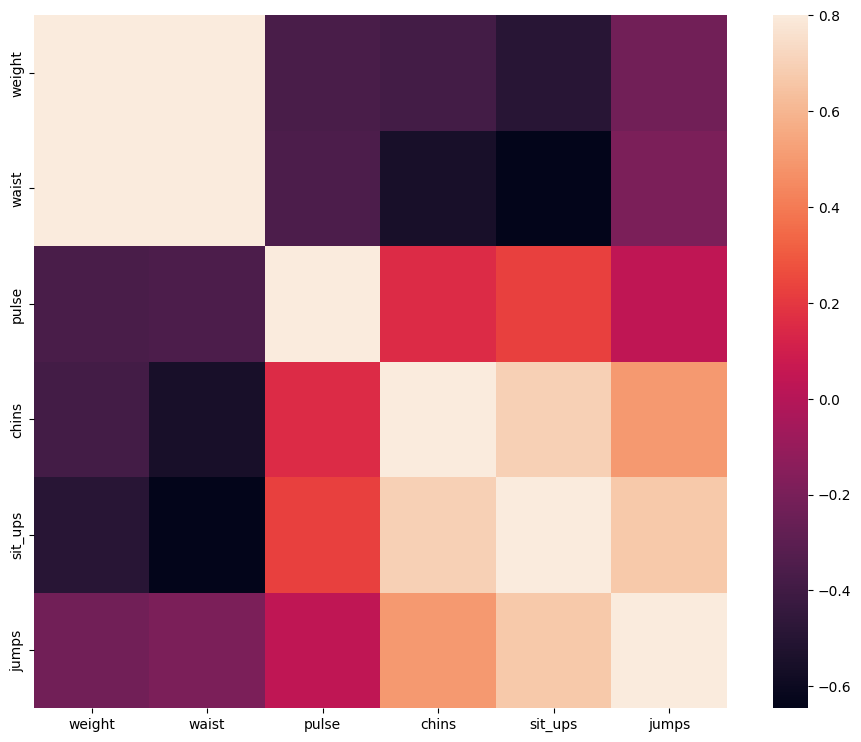

In [7]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [8]:
from sklearn.model_selection import train_test_split

# Split into validation and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15, 3), (5, 3), (15, 3), (5, 3))

In [9]:
# preprocess input and output data
from sklearn import preprocessing

# normal Gaussian scaling for inputs
X_scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = X_scaler.transform(X_train)

print(X_scaler.mean_)
print(X_scaler.var_)

[  9.06666667 161.6         77.8       ]
[  28.46222222 3795.17333333 2861.62666667]


In [10]:
# linear scaling upto [0,1] for outputs
y_scaler = preprocessing.MinMaxScaler().fit(y_train)
y_scaled = y_scaler.transform(y_train)

print(y_scaler.scale_)
print(y_scaler.min_)

[0.00917431 0.06666667 0.03571429]
[-1.26605505 -2.06666667 -1.64285714]


In [11]:
# a class for the preceptron layer
class Perceptron_Layer():
  def __init__(self, no_features, no_labels):
    self.w = torch.tensor(np.random.rand(no_features,no_labels), dtype=torch.double)
    self.b = torch.zeros([no_labels], dtype=torch.double)

  def __call__(self, x):
    u = torch.matmul(torch.tensor(x), self.w) + self.b
    y = torch.sigmoid(u)
    return y

def loss_fn(predicted_y, target_y):
    return torch.mean(torch.square(predicted_y - torch.tensor(target_y)))

def train(model, inputs, outputs, learning_rate):
    y = model(inputs)
    dy = y*(1-y)
    grad_u = -(torch.tensor(outputs) - y)*dy
    grad_w = torch.matmul(torch.transpose(torch.tensor(inputs), 0, 1), grad_u)
    grad_b = torch.sum(grad_u, dim = 0)
    
    model.w -= learning_rate * grad_w
    model.b -= learning_rate * grad_b

In [12]:
no_features, no_labels = 3, 3
model = Perceptron_Layer(no_features, no_labels)

print('w: {}, b: {}'.format(model.w.numpy(), model.b.numpy()))

w: [[0.54340494 0.27836939 0.42451759]
 [0.84477613 0.00471886 0.12156912]
 [0.67074908 0.82585276 0.13670659]], b: [0. 0. 0.]


In [13]:
no_epochs, lr = 10000, 0.001
cost = []
t = 0
idx = np.arange(len(X_scaled))
for epoch in range(no_epochs):
    
    np.random.shuffle(idx)
    
    y_pred = model(X_scaled[idx])
    loss = loss_fn(y_pred, y_scaled[idx])
    
    start = time.time()
    train(model, X_scaled[idx], y_scaled[idx], lr)
    t += time.time() - start
    cost.append(loss)

    if epoch%1000 == 999:
        print('epoch:{}, loss:{}'.format(epoch+1,cost[epoch]))

print('time for a weight update: %2.5f'%(t*1000/no_epochs))
print('w: {}, b: {}'.format(model.w.numpy(), model.b.numpy()))

epoch:1000, loss:0.06394892990570825
epoch:2000, loss:0.047659786924805735
epoch:3000, loss:0.04549999072483405
epoch:4000, loss:0.044570934982383806
epoch:5000, loss:0.044010306988840495
epoch:6000, loss:0.04361062153554822
epoch:7000, loss:0.04330200407966505
epoch:8000, loss:0.04305438566667594
epoch:9000, loss:0.04285173901611329
epoch:10000, loss:0.0426840091036014
time for a weight update: 0.07307
w: [[ 0.02181332 -0.28072956  0.10543114]
 [-0.63641939 -0.86665438  0.39965294]
 [ 0.14025573  0.52016199 -0.31047625]], b: [-0.61375943 -1.17091157 -0.58438207]


Text(0.5, 1.0, 'gd with alpha = 0.001')

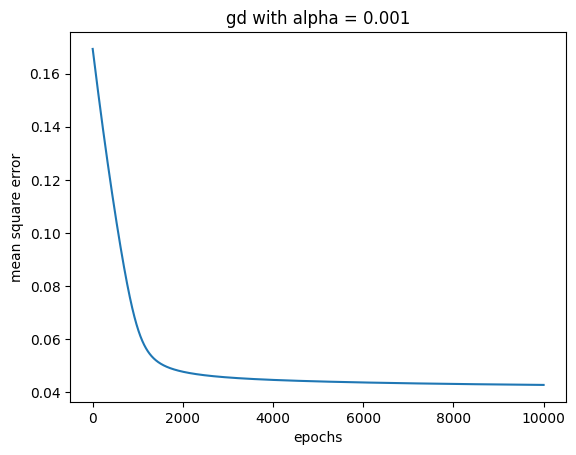

In [14]:
# plot learning curves
plt.figure(1)
plt.plot(range(no_epochs), cost)
plt.xlabel('epochs')
plt.ylabel('mean square error')
plt.title('gd with alpha = {}'.format(lr))

In [21]:
X_scaled = X_scaler.transform(X_test)
y_pred = model(X_scaled)
#y_scaled = (y_pred - torch.tensor(y_scaler.min_))/torch.tensor(y_scaler.scale_)
y_scaled = y_scaler.inverse_transform(y_pred.detach().numpy())
loss = loss_fn(torch.tensor(y_scaled, dtype=torch.float), y_test).item()

print(y_scaled, y_test)
print(loss)

[[189.12466723  35.2568241   55.56086718]
 [199.99186844  38.54345309  53.32745835]
 [189.87419301  36.14730902  54.87596576]
 [185.56403779  33.9907707   56.79259448]
 [194.81755658  37.57784685  53.23575699]] [[162.  35.  62.]
 [176.  37.  54.]
 [211.  38.  56.]
 [169.  34.  50.]
 [193.  38.  58.]]
143.56015858920873


In [22]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_scaled, y_test, squared=True, multioutput='raw_values')
rms

array([407.06558087,   1.21179368,  22.40310961])

In [23]:
from sklearn.metrics import r2_score

r2 = r2_score(y_scaled, y_test,  multioutput='raw_values')
r2

array([-15.16134924,   0.53783585, -11.22642492])

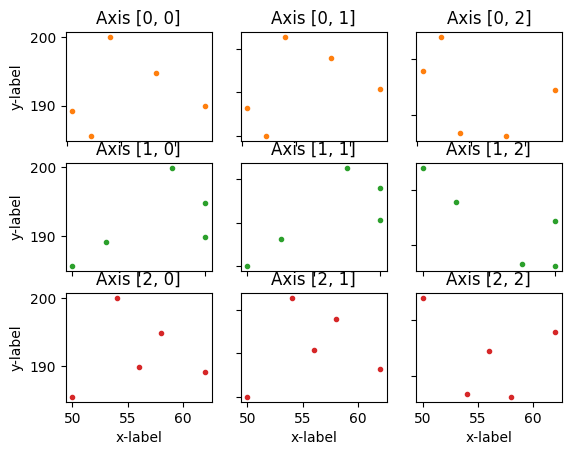

In [24]:
fig, axs = plt.subplots(3, 3)
axs[0, 0].plot(y_test[:,0], y_hat[:,0], 'tab:orange', marker='.', linestyle='none')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(y_test[:,0], y_hat[:,1], 'tab:orange', marker='.', linestyle='none')
axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(y_test[:,0], y_hat[:,2], 'tab:orange', marker='.', linestyle='none')
axs[0, 2].set_title('Axis [0, 2]')
axs[1, 0].plot(y_test[:,1], y_hat[:,0], 'tab:green', marker='.', linestyle='none')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(y_test[:,1], y_hat[:,1], 'tab:green', marker='.', linestyle='none')
axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(y_test[:,1], y_hat[:,2], 'tab:green', marker='.', linestyle='none')
axs[1, 2].set_title('Axis [1, 2]')
axs[2, 0].plot(y_test[:,2], y_hat[:,0], 'tab:red', marker='.', linestyle='none')
axs[2, 0].set_title('Axis [2, 0]')
axs[2, 1].plot(y_test[:,2], y_hat[:,1], 'tab:red', marker='.', linestyle='none')
axs[2, 1].set_title('Axis [2, 1]')
axs[2, 2].plot(y_test[:,2], y_hat[:,2], 'tab:red', marker='.', linestyle='none')
axs[2, 2].set_title('Axis [2, 2]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

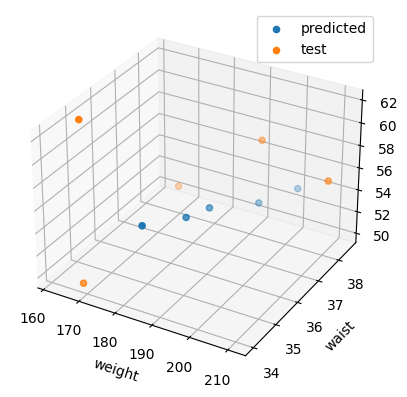

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(y_hat[:,0], y_scaled[:,1], y_scaled[:,2], label='predicted')
ax.scatter(y_test[:,0], y_test[:,1], y_test[:,2], label = 'test')

ax.set_xlabel('weight')
ax.set_ylabel('waist')
ax.set_zlabel('pulse')
plt.legend()